In [1]:
!pip install geopandas
!pip install seaborn
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


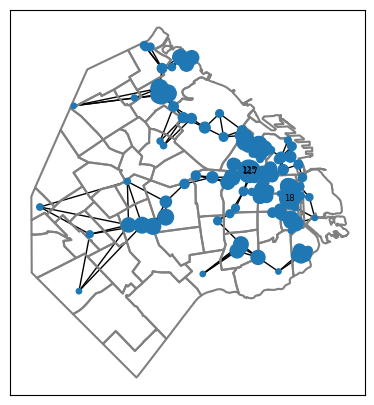

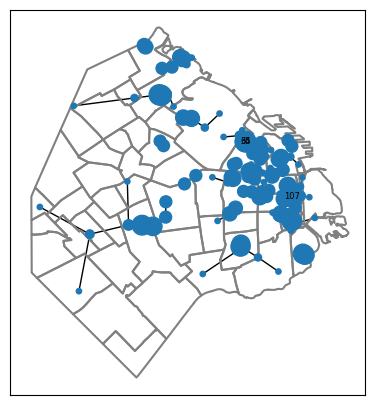

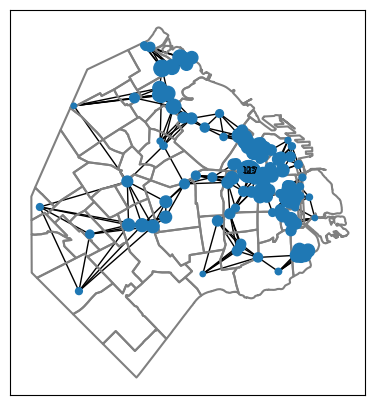

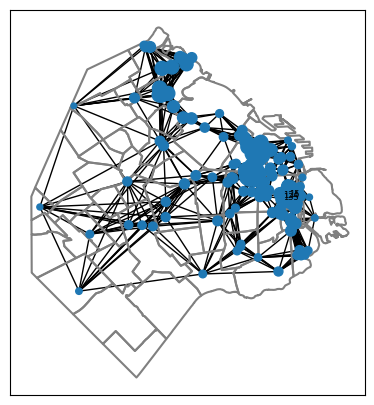

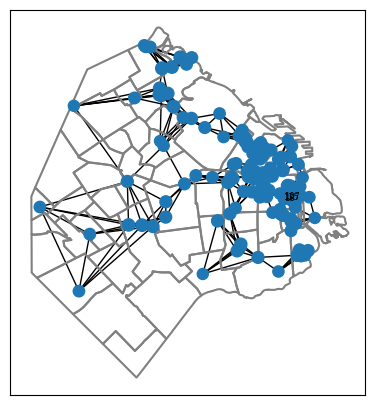

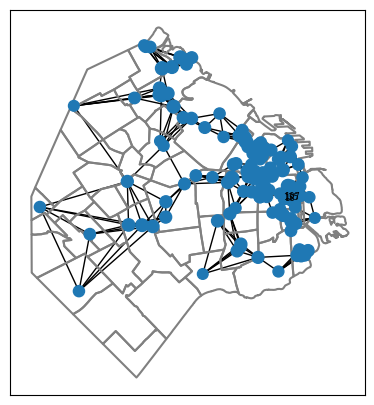

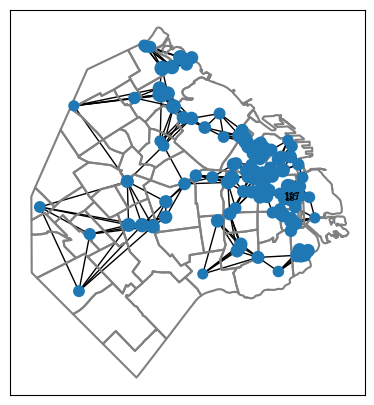

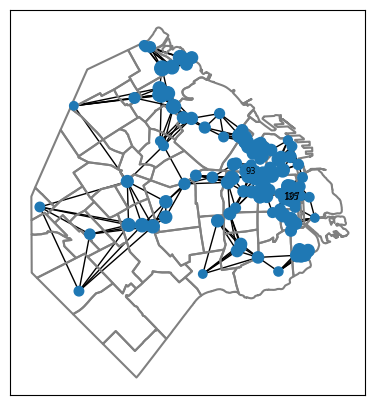

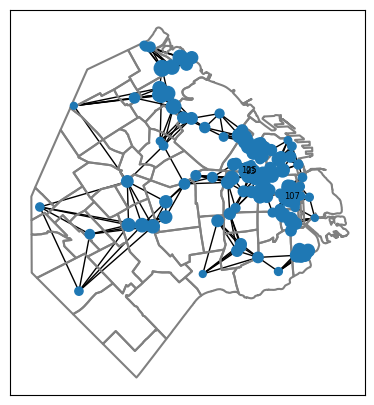

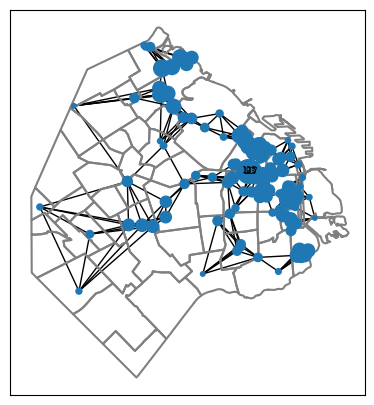

In [2]:
# Carga de paquetes necesarios para graficar

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
import math
import funciones_exocet as tf 
import funciones_exocet_2 as tf2

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [3]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<AxesSubplot: >

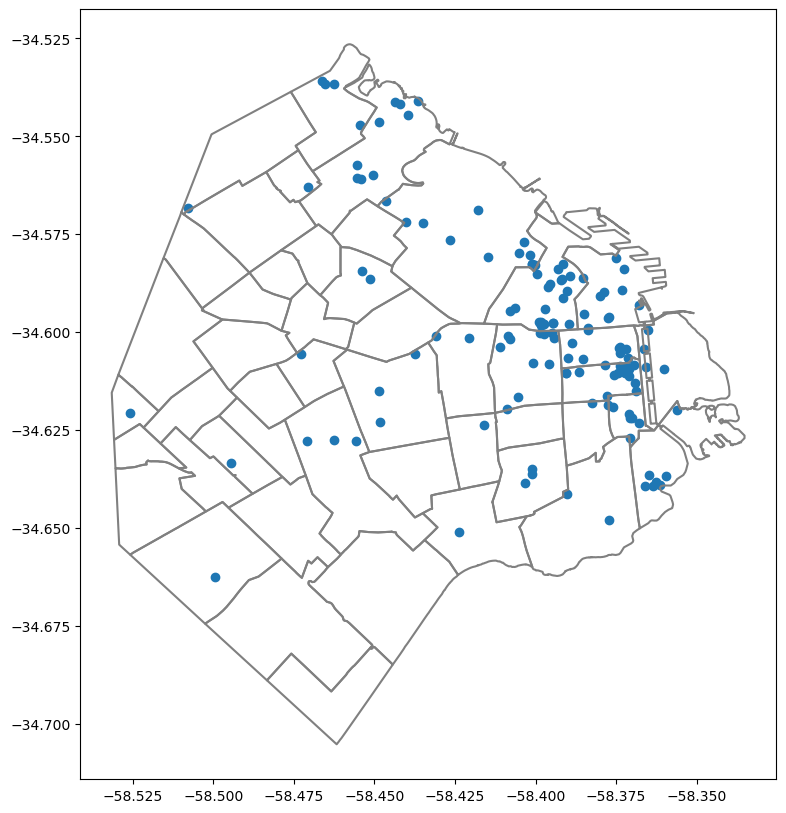

In [4]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [5]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [6]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [7]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

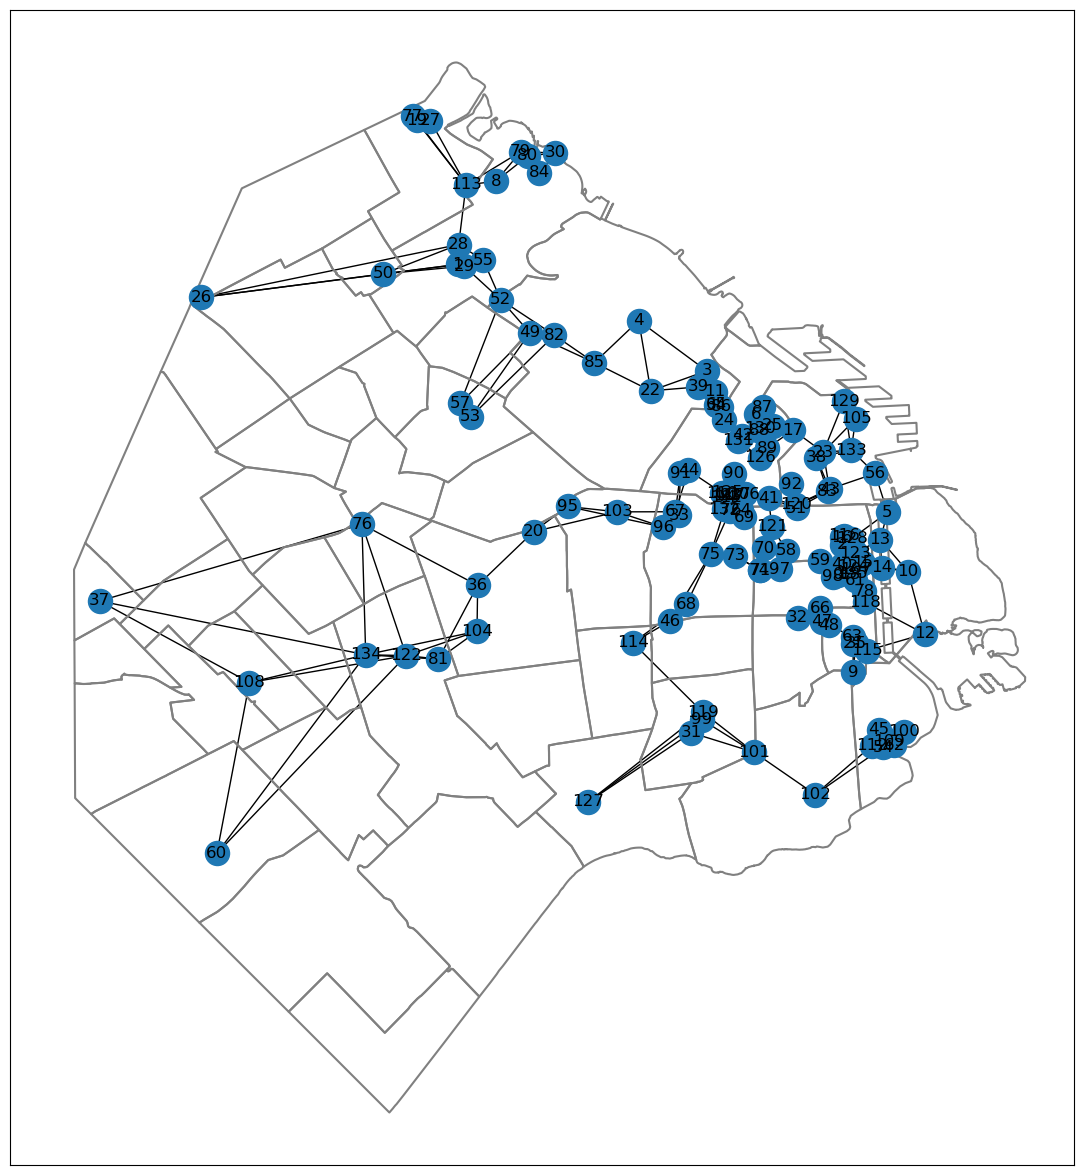

In [8]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:
Buscamos llegar a $M = \frac{N}{\alpha} (I - (1 - \alpha) C)$ y $b=1$  

Partimos de la ecuación de $p = (1 - \alpha) C p + \frac{\alpha}{N} 1$  

Ahora pasamos restando el término  $(1 - \alpha) C p$  para el otro lado entonces nos queda la ecuación: $p - (1 - \alpha) C p = \frac{\alpha}{N} 1$  

Luego sacamos Factor Común **$p$** y nos queda la siguiente ecuación:  $ (I-(1 - \alpha)C) p = \frac{\alpha}{N} 1$

Por último pasamos diviendo el término $\frac{\alpha}{N}$ y obtenemos lo siguiente: $  \frac{N}{\alpha} (I-(1 - \alpha)C) p = 1$

Y de esa manera conseguimos lo que buscabamos $Mp=b$ con $M = \frac{N}{\alpha} (I - (1 - \alpha) C)$ y $b=1$ 



## Punto 2:
Las condiciones que se deben cumplir es basicamente que la matriz M sea inversible y eso se puede ver de varias maneras:

**1**.Determinante de la matriz debe ser distinto de 0  
**2**.Las filas de la matriz tienen que ser Linealmente Independientes  
**3**.El núcleo tiene que ser solo el 0  
**4**.La matriz debe ser estrictamente diagonal dominante

Pero lo vamos a demostrar de la siguiente manera:  
Tomando $B = (1 - \alpha) C$  
Sabiendo que $||B||_1$< 1 (ya que $C$ es estocástica porque la suma de sus columnas es 1  y esta siendo multiplicada por un escalar menor que 1  

Queremos probar por el absurdo que $(I-B)$ es inversible utilizando la siguiente ecuación:  

$(I-B)x=0$ con $x\neq0$  

Hacemos la distributiva del producto:   

$x-Bx=0$ 

Despejamos $x$:  

$Bx=x$ 

Aplicamos norma 1 en ambos lados:  

$||Bx||_1=||x||_1$   

Por propiedad de Normas Inducidas sabemos que:   

$||Bx||_1 \leq ||B||_1 ||x||_1$  

Por lo tanto como $||Bx||_1=||x||_1$ entonces:  

$||x||_1 \leq ||B||_1 ||x||_1$  

Como $||x||_1$ es distinto de 0, dividimos ambos lados de la ecuación por $||x||_1$:    

$1 \leq ||B||_1$  

Sabemos que esto es un absurdo puesto que $||B||_1$< 1 por lo tanto probamos que $(I-B)$ es inversible.

A partir de esto, como $M = \frac{N}{\alpha} (I - B)$ y $\frac{N}{\alpha}$ es un escalar que no modifica su inversibilidad, podemos concluir que $M$ es inversible si $0<\alpha<1$. 




## Punto 3:

## Punto 3)a)

[18, 125, 117]


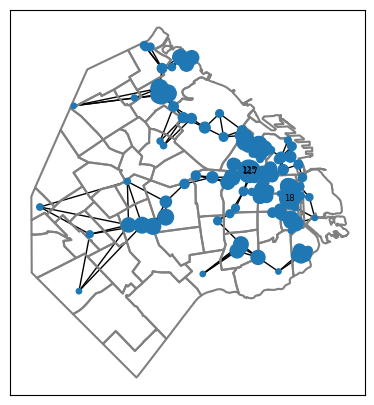

In [9]:
top0,pr0 = tf.grafico(D,3,1/5)
ltops = [top0]
ltops = (tf.juntar_Arrays(ltops))
print(ltops)

## Punto 3)b)

[34, 107, 65, 117, 125, 93, 15, 135, 124]


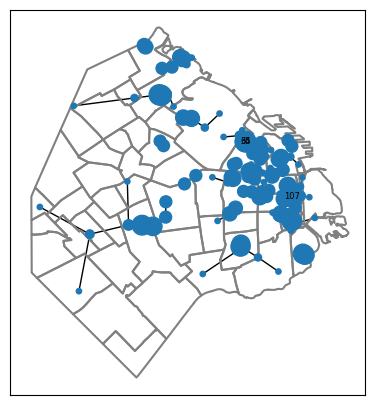

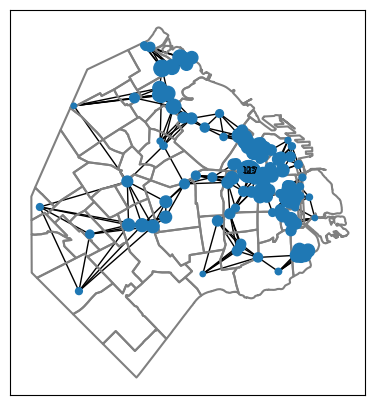

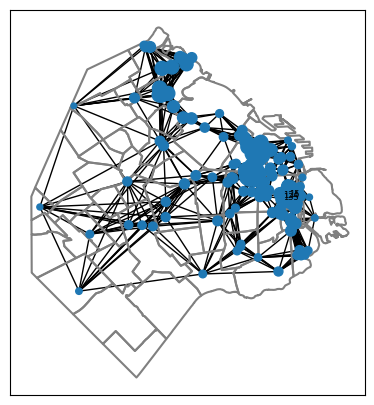

In [10]:
top1,pr1 = tf.grafico(D,1,1/5)
top2,pr2=tf.grafico(D,5,1/5)
top3,pr3=tf.grafico(D,10,1/5)
ltopsb = [top1,top2,top3]
ltopsb = (tf.juntar_Arrays(ltopsb))
print(ltopsb)


## Punto 3)c)

[18, 135, 107, 93, 125, 117]


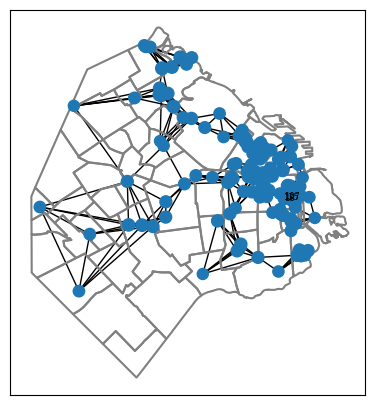

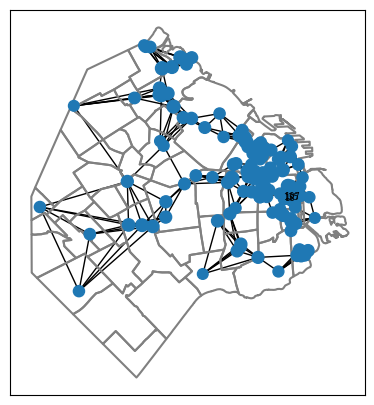

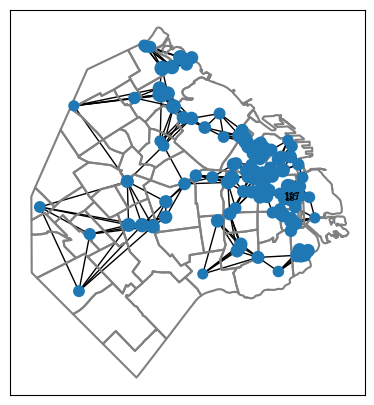

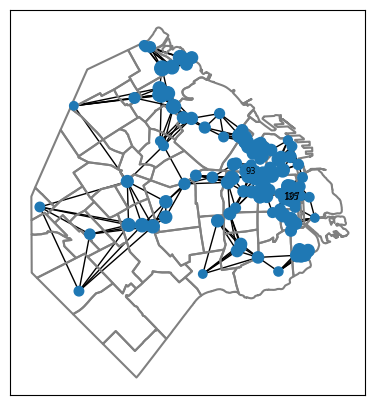

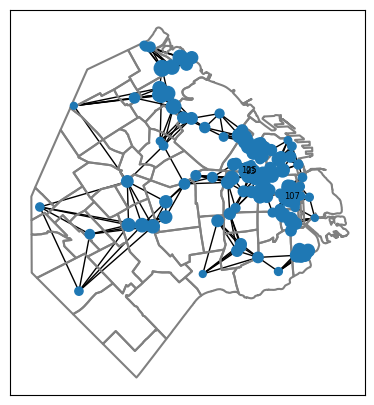

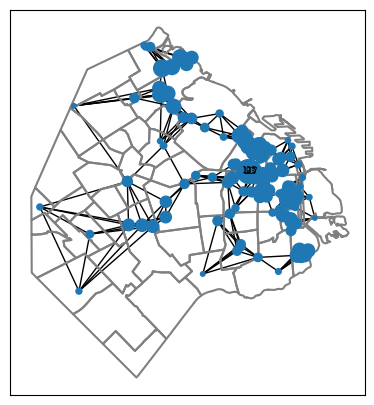

In [11]:
top4,pr4=tf.grafico(D,5,6/7)
top5,pr5=tf.grafico(D,5,4/5)
top6,pr6=tf.grafico(D,5,2/3)
top7,pr7=tf.grafico(D,5,1/2)
top8,pr8=tf.grafico(D,5,1/3)
top9,pr9=tf.grafico(D,5,1/7)
ltopsc = [top4,top5,top6,top7,top8,top9]
ltopsc = (tf.juntar_Arrays(ltopsc))
print(ltopsc)

## Punto 3)a)a)
Las siguientes dos funciones se encargan de mostrar que ocurre con los museo principales cuando se modifica el $m$ o el $\alpha$.  
La funcion graficadoraM se ocupa de la variacion de $m$ mientras que graficadoraA lo hace para $\alpha$

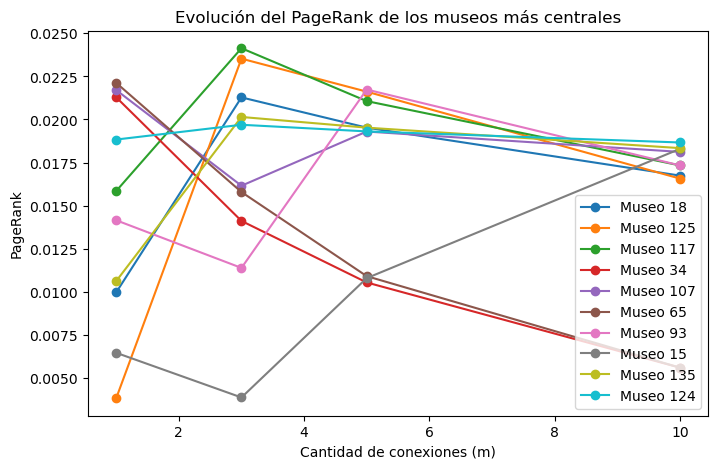

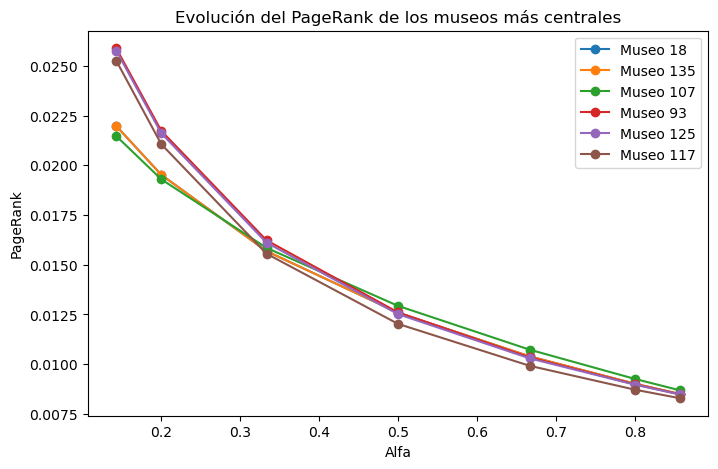

In [12]:
tf.graficadoraM()

tf.graficadoraA()

## CONCLUSIONES

    En el caso de variación de la cantidad de conexiones, mostrado en el primer gráfico, se puede observar que las posiciones de la mayoría de los museos varía enormemente, con la excepción del museo 124, el cual mantuvo su PageRanking a pesar de las variaciones. También puede verse como se crea un grupo mayoritario de museos que cuando m llega a 10 poseen un puntaje parecido, de los cuales la mayor parte de estos empezaron con una posición baja en el PageRanking. Existe otro grupo el cual consiste de solo dos museos el 34 y el 65, que a pesar de haber tenido el puntaje mas alto al empezar, terminaron al final de la lista.
    
    Por otro lado, en el segundo gráfico que muestra la variación del valor de alpha, denota un estable decreso de su ranking a lo largo de su recorrido. Esto se debe a que alpha representa la posibilidad de que las personas se muevan a otros museos que no estan conectados, es por eso que el cambio entre los museos con más Pagerank es aleatorio, ya que las conexiones pierden importancia dando paso a intercambios mas variados. Más alla de eso podemos ver que casi todos los museos muestran un comportamiento similar de perder Pagerank a medida que alpha aumenta. Lo único destacable seria que los museos 93, 125, 117 inician con un un valor mayor pero al subir el alpha se emparejan con el resto llegando a resultados muy parecidos a pesar de destacar cuando el alpha es menor.

    

## Punto 3)b)b)

    Mirando el cambio que sufren los gráficos al variar la cantidad de conexiones, vemos que cuando m es chico, en nuestro caso entre 1 y 3, existen dos focos, el primero está en las Comunas 2 y el norte de la 3, mientras que la segunda se mantiene la Comuna 1 en el borde entre San Nicolás, Monstserrat y Puerto Madero. Al aumentar m, en nuestro caso cuando m es 5, los principales museos se encuentran en el borde de la comuna 2 y 3, que previamente habia sido uno de los centros cuando m era menor. Por último, cuando m aumenta a 10, el centro de importancia se mueve hacia la Comuna 1, en la misma zona que antes hubo el ya mencionado centro cuando m estaba entre 1 y 3.

    En el caso de la alteración del alpha, se observa que a medida que crece el alpha los museos que inicialmente estaban predominando en la zona del borde entre las Comunas 2 y 3 perdieron relevancia, siendo opacados por los museos ubicados en el centro a la derecha de la Comuna 1. Hay que notar que estos centros son los mismos que aparecieron cuando miramos que pasaba cuando m era 5 y 10 respectivamente.

## Punto 4:
Para este punto partimos de la ecuación:  
$$\mathbf{v} = B^{-1} \mathbf{w}$$ siendo **w** el vector que en cada componente tiene la cantidad total de visitantes por museo y $B = \sum_{k=0}^{r-1} C^k$  

Se busca probar que **v** es el vector que tiene en cada componente la cantidad de personas que tuvieron ese museo como entrada.  

Asumiendo que B es inversible podemos llegar a la siguiente ecuación: $$ B\mathbf{v} = \mathbf{w}$$

De acá tomamos B genérica: ($C^0+C^1+C^2+...+C^{(r-1)}$) y  tambien el **w** genérico: ($w_0,w_1,w_2,...,w_{(r-1)}$)

Si ahora hacemos el producto de B por **v**=$v_0$ obtenemos el siguiente resultado: ($C^0*v_0+C^1*v_0+C^2*v_0+...+C^{(r-1)}*v_0$)  

Y por último igualamos ambos vectores ($C^0*v_0+C^1*v_0+C^2*v_0+...+C^{(r-1)}*v_0$)  = ($w_0,w_1,w_2,...,w_{(r-1)}$)  

Viendo que $C^0*v_0$ es la cantidad de personas que ingresaron a los museos en el paso inicial, sabiendo tambien $C^1*v_0$ es de la misma forma el total de ingresantes en el siguiente paso, y de esta manera sucesivamente para todos los productos hasta llegar a $C^{(r-1)}*v_0$. Podemos concluir que la suma de todos ellos nos van a dar el resultado total de todas las personas que visitaron cada museo, en un vector que es exactamente lo mismo a lo que nosotros conocemos que es **w**, siempre y cuando $v_0$ cumpla con las hipotesis dadas como consigna en el ejercicio.


De esa manera se consigue probar lo que queriamos, ya que como $Bv_0 = \mathbf{w}$ y **v**=$v_0$, entonces $ B\mathbf{v} = \mathbf{w}$, y ademas como B es inversible obtenemos la ecuacion buscada:$$\mathbf{v} = B^{-1} \mathbf{w}$$


## Punto 5:

En la siguiente celda se invoca a la función norma_vectorV que tomara como parametro a la Matriz de Distancias ($D$) y 
devuelve luego de su ejecución la norma  1  del  vector $v$ mostrando de esa manera la cantidad total de visitantes que ingresaron en la red.

In [13]:
w = np.loadtxt("visitas.txt")
tf.norma_vectorV(D,w)

FileNotFoundError: visitas.txt not found.

## Punto 6:

A continuación se llama a la función error_estimado que recibe a la Matriz de Distancias ($D$) y devuelve una estimación de la cota para el error de $v$ y ademas el numero de condición de $B$ como lo solicita la consigna.


In [ ]:
tf.error_estimado(D)


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = tf.calcula_pagerank(A,1)# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

# 1)a)

Nos piden probar que el vector de 1 es autovector tanto de la matriz L como de R y también indicar cual es su autovalor asociado. Comenzaremos a demostrar con L:
Utilizamos la siguiente ecuación asumiendo que es L es diagonalizable planteamos: $L1=\lambda1$  

Sabiendo que $L=K-A$ con A la matriz de adyacencia y K la matriz diagonal con la suma de las filas de A en su diagonal reemplazamos: $(K-A)1=\lambda1$  

Distribuimos el producto y nos queda: $K1-A1=\lambda1$  

Ahora tomamos la fila i para poder chequear la condición: $(K1)_i-(A1)_i=\lambda1$  

Haciendo el producto de K por el vector de 1, sabiendo que K es una matriz diagonal con la suma de las filas de A en sus valores, por lo tanto al hacer esa multiplicación y agarrando la fila i, $(K1)_i$ esto nos deberia devolver $k_i$  

Ahora para el caso de A por el vector de 1, la situación es algo distinta, A posee más elementos que solo la diagonal entonces cuando realizamos ese producto y tomamos la fila i obtenemos una sumatoria de todos los valores de la fila i de A que se escribe de la siguiente manera: $ \sum_{j=1}^{n} a_{ij}$   

Entonces nuestra ecuación nos queda $k_i-\sum_{j=1}^{n} a_{ij}=\lambda1$  

Pero justamente $k_i$ es la suma de las fila i de A que es exactamente lo mismo que $\sum_{j=1}^{n} a_{ij}$, entonces reemplazo $k_i$ por la sumatoria:
$k_i-k_i=\lambda1$  

Por lo tanto nos queda lo siguiente: $0=\lambda1$ y justamente como tenemos el vector de 1 esto se cumple si y solo si $\lambda=0$ 

Entonces concluimos que el vector de 1 es autovector de L si el autovalor asociado es 0.<br><br><br><br>  



      



Ahora tenemos que hacer lo mismo con la matriz R de una manera similar asumimos R diagonalizable con el vector de 1 y proponemos la siguiente ecuación:
 $R1=\lambda1$  
 
Sabemos que $R=A-P$ con A la matriz de adyacencia y P la matriz que se forma haciendo $P_{ij}= \frac{k_ik_j}{2E} $ y utilizando tambien que $2E = \sum_{i=1}^{N} \sum_{j=1}^{N} A_{ij}$      

Distribuimos el producto y nos queda: $A1-P1=\lambda1$   

Ahora tomamos la fila i para poder chequear la condición: $(A1)_i-(P1)_i=\lambda1$   

Para $(A1)_i$ usamos lo mismo de antes por lo tanto nos quedaría:$ \sum_{j=1}^{n} a_{ij}$ y también como dijimos antes eso es igual a $k_i$.    

La otra cuenta de $(P1)_i$ se vuelve un poco mas interesante ya que seria sumar nuevamente todos los elementos de la fila i pero recordemos que los componentes de P se escriben de la siguiente manera $P_{ij}= \frac{k_ik_j}{2E} $ entonces la sumatoria nos quedaria algo de la siguiente manera: 
$\sum_{j=1}^{N} \frac{k_i k_j}{2E} $.    

Volviendo a la ecuación y reemplazando los valores tenemos: $k_i -\sum_{j=1}^{N} \frac{k_i k_j}{2E} = \lambda1$   

Ahora centrandonos principalmente en la sumatoria podemos ver que podriamos sacar tanto el $k_i$ como el $2E$ como factor común, ya que el primero no depende de $j$ y el segundo es un número, la clave ahora es que nos quedaría algo asi $\frac{k_i}{2E} \sum_{j=1}^{N} k_j $.  

Luego si miramos con cuidado esto: $\sum_{j=1}^{N} k_j $ se puede ver que si vamos cambiando el sub índice de $k_j$ estaremos pasando por todas los componentes de la Matriz K y sabemos que cada elemento de K ya tiene la sumatoria de las filas de A y ahora estamos sumando esos valores por cada columna por lo tanto la sumatoria $\sum_{j=1}^{N} k_j $ seria lo mismo que hacer $\sum_{i=1}^{N} \sum_{j=1}^{N} A_{ij}$ ya que estariamos sumando toda la Matriz A indirectamente o de manera mas compacta si se quiere decir y como ya sabiamos que $\sum_{i=1}^{N} \sum_{j=1}^{N} A_{ij} = 2E$ podemos concluir que la $\sum_{j=1}^{N} k_j  = 2E$   

Habiamos obtenido $\frac{k_i}{2E} \sum_{j=1}^{N} k_j $ y ahora sabemos que $\sum_{j=1}^{N} k_j  = 2E$, entonces reemplazando nos queda $\frac{k_i}{2E} *2E$, cancelando los 2E llegamos a la conclusión de que $(P1)_i$ = $k_i$.   

Habiendo obtenido todo lo anterior volvemos a la ecuación reemplazando los valores de $(A1)_i$ y $(P1)_i$:   

Nos quedaría algo asi: $k_i-k_i=\lambda1$     

En tal caso igual que antes tenemos: $0=\lambda1$ y justamente al tener el vector de 1 esto se cumple si y solo si $\lambda=0$     

Entonces concluimos que el vector de 1 es autovector de R si el autovalor asociado es 0.  

En consecuencia podemos afirmar que el vector de 1 es autovector de tanto L y R si y solo si el autovalor asociado es el 0 como nos pedian.    

Por último nos pedian describir que agrupacion de la red representaba y justamente muestra el de que no haya variacion, ya que todos pertenecerian al mismo grupo y no tendrian posibilidad de cambiar. REVISAR/COMPLETAR

# Punto 1)b)

En este punto nos piden probar que agarrando L o R, con dos autovectores 

# Punto 1)c)

Para este punto, lo vamos a demostrar utilizando a $L$

Tenemos que $L=L^{t}$, entonces tenemos que $Lv = L^{t}v = \lambda{v}$

si multiplicamos por el vector de unos $1^{t}$

$1^{t}L^{t}v = 1^{t}\lambda{v}$

Notemos que $1^{t}L^{t}v = (L1)^{t}v = \vec{0}^{t}v = 0$

Y que $1^{t}\lambda{v} = \lambda{1}^{t}{v} = \lambda\sum_{i}v_{i}$

Por lo tanto $0 = \lambda\sum_{i}v_{i}$ y como $\lambda \neq 0$ llegamos a que $\sum_{i}v_{i} = 0$




# Punto 2)a)

Nos piden probar que los autovalores de $M+\mu I$ son de la forma $\gamma_i=\lambda_i+\mu$ y el autovector asociado es $v_i$. Ademas nos indican que debemos probar que si $\lambda_i+\mu \neq 0$ entonces $M+\mu I$ es inversible.  

Comenzamos viendo los autovalores, como sabemos que $M$ es diagonalizable con el autovalor $\lambda_i$ y el autovector asociado $v_i$ por lo tanto planteamos la siguiente ecuacion:  $Mv_i=\lambda_i v_i$  

Ahora sumamos a ambos lados de la ecuacion el termino $\mu I v_i$ y nos queda: $Mv_i+\mu I v_i=\lambda_i v_i+\mu I v_i$  

Luego podemos sacar factor comun $v_i$ hacia la izquierda dejandonos la siguiente ecuacion: $(M+\mu I)v_i=(\lambda_i+\mu)v_i$   

Reemplazando $\gamma_i=\lambda_i+\mu$ nos termina quedando: $(M+\mu I)v_i=\gamma_i v_i$  

Y esto justamente es lo que buscabamos llegamos a la expresion de que el autovalor asociado a $M+\mu I$ es $\gamma_i=\lambda_i+\mu$ y su autovector relacionado es $v_i$, de esta manera llegamos a la ecuacion que nos permite confirmar esa proposicion.  

Bien ahora nos queda mostrar la segunda parte de que si $\lambda_i+\mu \neq 0$ entonces $M+\mu I$ es inversible:  

Utilizamos ahora que ya sabemos que: $(M+\mu I)v_i=(\lambda_i+\mu)v_i$ por lo tanto ambas expresiones son equivalentes.  

Empezamos diciendo que$(\lambda_i+\mu)v_i\neq 0$ pero por enunciado ya sabemos que $(\lambda_i+\mu)\neq 0$ por lo tanto la unica manera de cumplir la desigualdad es que $v_i \neq 0$.  

Y ahora como mostramos antes que ambas expresiones son lo mismo y tambien queremos que ver que se cumpla que $(M+\mu I)v_i \neq 0$ y por la desigualdad anterior sabemos que $v_i \neq 0$, y por lo tanto estariamos afirmando que $M+\mu I\neq 0$ que es exactamente lo mismo que decir que la matriz $M+\mu I$ es inversible que es lo que buscabamos.  

Por lo tanto pudimos demostrar ambas condiciones que se nos pedian en el inciso.





# Punto 2)b) COMPLETAR

$Lv = 0$ con $v \neq \vec{0}$

Como $L$ es semidefinida positiva, sabemos que $\lambda_{i} \geq 0 \forall i$

Por lo demostrado en el punto 2)a), los autovalores de $L + \mu{Id}$ son $\lambda_{i} + \mu$

Usando que  $\lambda_{i} \geq 0$ y $\mu > 0$, podemos ver que $\lambda_{i} + \mu \neq 0 \forall i$ entonces $L + \mu{Id}$ es inversible

Por lo tanto, podemos afirmar que existe $(L + \mu{Id})^{-1}$

## Punto 2)c)

Para ver que $\tilde{M}$ tiene a $v_{1}$ como autovectoe de autovalor $0$ vemos:

$ \tilde{M} = M - \lambda_1 \frac{v_1v_{1}^{t}}{v_{1}^{t}v_1} $

Multiplicamos ambos lados por $v_{1}$ y lo distribuimos

$ \tilde{M}v_{1} = (M - \lambda_1 \frac{v_1v_{1}^{t}}{v_{1}^{t}v_1})v_{1} $ 

$ \tilde{M}v_{1} = Mv_{1} - \lambda_1 \frac{v_1v_{1}^{t}v_{1}}{v_{1}^{t}v_1} $ 

Simplificando arriba y abajo de la división 

$ \tilde{M}v_{1} = Mv_{1} - \lambda_1 {v_1} $ 

Como $v_{1}$ es autovector de $M$

$ \tilde{M}v_{1} = \lambda_1 {v_1} - \lambda_1 {v_1 }$

Sacamos $v_{1}$ como factor común

$ \tilde{M}v_{1} = (\lambda_1 - \lambda_1) {v_1} $

$ \tilde{M}v_{1} = 0 {v_1} $ 

Por lo tanto, el autovalor de $\tilde{M}$ de autovector $v_{1}$ es $0$<br><br><br> 
    

Ahora para ver que $\tilde{M}$ tiene los mismos autovectores y autovalores que $M$, exceptuando $v_{1}$ y $\lambda_1$ que vimos previamente :

$ \tilde{M} = M - \lambda_1 \frac{v_1v_{1}^{t}}{v_{1}^{t}v_1} $

Multiplicamos ambos lados por $v_{i}$ y lo distribuimos

$ \tilde{M}v_{i} = (M - \lambda_1 \frac{v_1v_{1}^{t}}{v_{1}^{t}v_1})v_{i} $ 

$ \tilde{M}v_{i} = Mv_{i} - \lambda_1 \frac{v_1v_{1}^{t}v_{i}}{v_{1}^{t}v_1} $ 

Como los autovectores forman una base, entonces $v_{1}^{t}v_{i}v_{i} = 0$

$ \tilde{M}v_{i} = Mv_{i} - \lambda_1 \frac{0}{v_{1}^{t}v_1} $ 

$ \tilde{M}v_{i} = Mv_{i} - 0 $ 

como $v_{i}$ es autovector de $M$

$ \tilde{M}v_{i} = \lambda_i {v_i} $

Lo que confirma que $\tilde{M}v_{i} $ comparte el resto de los autovalores y autovectores con $M$

# Punto 3)

# Punto 3)a)

## Punto 3)b)


In [58]:
A_ejemplo = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
])
L=tf2.calcula_L(A_ejemplo)
R=tf2.calcula_R(A_ejemplo)

mu=1

v_Lchico,_,_=tf2.metpotI2(L,mu,tol=1e-8,maxrep=np.inf)
v_Rmayor,_,_=tf2.metpot1(R,tol=1e-8,maxrep=np.inf)
print(v_Lchico)
print(v_Rmayor)

s_L = np.sign(v_Lchico)
print(s_L)

s_R = np.sign(v_Rmayor)
print(s_R)



[-0.42535606 -0.42537159 -0.26291319 -0.26290758  0.26282505  0.26281901
  0.42529984  0.4252725 ]
[ 0.39410263  0.39410263  0.30774719  0.30766525 -0.30766525 -0.30774719
 -0.39410263 -0.39410263]
[-1. -1. -1. -1.  1.  1.  1.  1.]
[ 1.  1.  1.  1. -1. -1. -1. -1.]


# Punto 4)

In [59]:
cortes=tf2.laplaciano_iterativo(A_ejemplo,2)


print(cortes)


[[2, 3], [0, 1], [5, 6], [4, 7]]


In [53]:
A3 = construye_adyacencia(D,3)
A5 = construye_adyacencia(D,5)
A10 = construye_adyacencia(D,10)
A50 = construye_adyacencia(D,50)
print(A10)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [54]:
L3=tf2.laplaciano_iterativo(A3,3)
L5=tf2.laplaciano_iterativo(A5,3)
L10=tf2.laplaciano_iterativo(A10,3)
L50=tf2.laplaciano_iterativo(A50,3)
print(L10)

[[], [0, 2, 5, 9, 10, 12, 13, 14, 15, 16, 18, 21, 31, 32, 35, 40, 45, 47, 48, 54, 56, 58, 59, 61, 62, 63, 66, 71, 74, 78, 97, 98, 99, 100, 101, 102, 107, 109, 112, 115, 116, 118, 119, 123, 124, 127, 128, 135], [43, 133], [83], [1, 8, 19, 27, 28, 29, 30, 50, 55, 77, 79, 80, 84, 113], [], [], [3, 4, 6, 7, 11, 17, 20, 22, 23, 24, 25, 26, 33, 34, 36, 37, 38, 39, 41, 42, 44, 46, 49, 51, 52, 53, 57, 60, 64, 65, 67, 68, 69, 70, 72, 73, 75, 76, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 103, 104, 105, 106, 108, 110, 111, 114, 117, 120, 121, 122, 125, 126, 129, 130, 131, 132, 134]]


In [57]:
M3=tf2.modularidad_iterativo(A3)
M5=tf2.modularidad_iterativo(A5)
M10=tf2.modularidad_iterativo(A10)
M50=tf2.modularidad_iterativo(A50)
print(M3)

[[7, 41, 44, 64, 69, 72, 75, 90, 93, 94, 106, 110, 111, 117, 125, 132], [46, 51, 58, 67, 68, 70, 71, 73, 74, 83, 91, 92, 114, 120, 121], [3, 4, 11, 22, 39], [33, 97], 9, 21, 32, 35, 47, 48, 63, 66, 115, [31, 99, 101, 119, 127], [45, 54, 62, 100, 102, 109, 112], [1, 26, 28, 29, 49, 50, 52, 53, 55, 57, 82, 85, 113], [8, 19, 27, 30, 77, 79, 80, 84], [95, 96, 103], [20, 36, 37, 60, 76, 81, 104, 108, 122, 134], [23, 24, 34, 38, 43, 56, 65, 86, 105, 129, 133], [6, 17, 25, 42, 87, 88, 89, 126, 130, 131], [2, 5, 16, 116, 128], [0, 10, 12, 13, 14, 15, 18, 40, 59, 61, 78, 98, 107, 118, 123, 124, 135]]


In [ ]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

